<a href="https://colab.research.google.com/github/rwightman/pytorch-image-models/blob/master/notebooks/EffResNetComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNets vs ResNets in PyTorch: On Why I Won't Be Tossing My ResNets

First off, I want to be clear that I am not panning EfficientNets (https://arxiv.org/abs/1905.11946) here. They are unprecident in their parameter and FLOP efficiency. Thanks Mingxing Tan, Quoc V. Le, and the Google Brain team for releasing the code and weights.

I dug into the EfficientNet paper the day it was released. I had recently implemented MobileNet-v3 and MNasNet architectures in PyTorch and EfficientNets have a lot in common with those models. After defining new model definitions strings, adding the depth scaling, and hacking together some weight porting code they were alive. 

First impressions were positive, "Wow, that's some impressive accuracy for so few parameters (and such small checkpoints)''. After spending more time with the models, training them, running numerous validations, etc. some realities sank in. These models are less efficient in actual use than I'd expected. I started doing more detailed comparisons with familiar ResNet models and that's how this notebook came to be...

## Objectives
A few points I'm hoping to illustrate in this notebook:

1. The efficiencies of EfficientNets may not translate to better real-world performance on all frameworks and hardware platforms.  Your trusty old ResNets may be just as good for your NN framework of choice running on an NVIDIA GPU. What consumes less resources in Tensorflow with an XLA optimized graph on a TPU, may end up being more resource hungry in PyTorch running with a CUDA backend.

2. The story of a ResNet-50 does not end with a top-1 of 76.3% on ImageNet-1k. Neither do the other ResNe(X)t networks end with the results of the original papers or the pretrained weights of canonical Caffe, Tensorflow, or PyTorch implementations. Many papers compare shiny new architectures trained with newer techniques (or algorithmically searched hyper-parameters) but don't give the ResNet baselines the same treatment. A ResNet-50 can be trained to well over 78% on ImageNet -- better than an 'original' ResNet-152 -- a 35M parameter difference!  I've selected better pretrained models to compare against the EfficientNets. 

3. Most PyTorch implementations of EfficientNet that I'm aware of are using the Tensorflow ported weights, like my 'tf_efficientnet_b*' models. These ported weights requires explicit padding ops to match the behaviour of Tensorflow 'SAME' padding. This padding adds a runtime penalty (about 2% for forward) and a memory penalty (reducing max batch sizes by roughly 15-20%). I've natively trained the B0 through B2 models in PyTorch now, but haven't made progress on B3 and up (very slow to train).

4. There are some nifty inference tricks, like test time pooling, that can breathe life into old models and allow them to be used outside of their standard resolutions without retraining. A few ResNets were run with TTP here at resolutions similar to the EffNet models as a comparison.

## Considerations

A few additional considerations:
* I'm only running the numbers on validation here to keep the Colab notebook sane. I have trained with all of the architectures, the relative differences in throughtput and memory usage/batch size limits fit my experience training as well.

* This comparison is for PyTorch 1.0/1.1 with a CUDA backend. Future versions of PyTorch, CUDA, or the PyTorch XLA TPU backend may change things significantly. I'm hoping to compare these models with the PyTorch XLA impl at some point. Not sure if it's ready yet?

* The analysis is for the ImageNet classification task. The extra resolution in all EfficientNet > b0 is arguably less beneficial for this task than say fine-grained classification, segmentation, object detection and other more interesting tasks. Since the input resolution is responsible for a large amount of the GPU memory use, and ResNets for those other tasks are also run at higher res, the comparisons made do highly depend on the task.

## What's TIMM and where are the models?

The `timm` module use here is a PyPi packaging of my PyTorch Image Models 
- https://github.com/rwightman/pytorch-image-models

Stand alone version of the EfficientNet, MobileNet-V3, MNasNet, etc can also be found at 
- https://github.com/rwightman/gen-efficientnet-pytorch

In [1]:
# Install necessary modules
!pip install timm

     |████████████████████████████████| 92kB 28.0MB/s 


In [2]:
# For our convenience, take a peek at what we're working with
!nvidia-smi

Mon Jul  1 20:17:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    15W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
# Import the core modules, check which GPU we end up with and scale batch size accordingly
import torch

# Flipping this on/off will change the memory dynamics, since I usually
# validate and train with it on, will leave it on by default
torch.backends.cudnn.benchmark = True

import timm
from timm.data import *
from timm.utils import *

import pynvml
from collections import OrderedDict
import logging
import time

def log_gpu_memory():
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    info.free = round(info.free / 1024**2)
    info.used = round(info.used / 1024**2)
    logging.info('GPU memory free: {}, memory used: {}'.format(info.free, info.used))
    return info.used

def get_gpu_memory_total():
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    info.total = round(info.total / 1024**2)
    return info.total
  
pynvml.nvmlInit()
setup_default_logging()
log_gpu_memory()

total_gpu_mem = get_gpu_memory_total()
if total_gpu_mem > 12300:
  logging.info('Running on a T4 GPU or other with > 12GB memory, setting batch size to 128')
  batch_size = 128
else:
  logging.info('Running on a K80 GPU or other with < 12GB memory, batch size set to 80')
  batch_size = 80

GPU memory free: 15080, memory used: 0
Running on a T4 GPU or other with > 12GB memory, setting batch size to 128


# ImageNet-'V2' Validation

If you're not aware, ImageNet-V2 (https://github.com/modestyachts/ImageNetV2) is a useful collection of 3 ImageNet-like validation sets that have been collected more recently, 10 years after the original ImageNet.

Aside from being conveniently smaller and easier to deploy in a notebook, it's a useful test set to compare how models might generalize beyond the original ImageNet-1k data. We're going to use the 'Matched Frequency' version of the dataset. There is a markedly lower accuracy rate across the board for this test set. It's very interesting to see how different models fall relative to each other. I've included an analysis of those differences at the bottom.


In [0]:
# Download and extract the dataset (note it's not actually a gz like the file says)
if not os.path.exists('./imagenetv2-matched-frequency'):
    !curl -s https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-matched-frequency.tar.gz | tar x
dataset = Dataset('./imagenetv2-matched-frequency/')
for i in range(len(dataset)): # warmup
    dummy = dataset[i]

In [0]:
# A basic validation routine with timing and accuracy metrics

def validate(model, loader):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    model.eval()
    #torch.cuda.reset_max_memory_allocated()
    #torch.cuda.reset_max_memory_cached()
    gpu_used_baseline = log_gpu_memory()
    gpu_used = 0
    start = end = time.time()
    num_batches = len(loader)
    log_iter = round(0.25 * num_batches)
    with torch.no_grad():
        for i, (input, target) in enumerate(loader):
            target = target.cuda()
            input = input.cuda()

            output = model(input)

            prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
            top1.update(prec1.item(), input.size(0))
            top5.update(prec5.item(), input.size(0))

            batch_time.update(time.time() - end)
            end = time.time()

            if i and i % log_iter == 0:
                if gpu_used == 0:
                    gpu_used = log_gpu_memory()
                logging.info(
                    'Test: [{0:>4d}/{1}]  '
                    'Time: {batch_time.val:.3f} ({batch_time.avg:.3f}) '
                    'Rate: {rate_avg:.3f} img/sec '
                    'Prec@1: {top1.val:>7.4f} ({top1.avg:>7.4f}) '
                    'Prec@5: {top5.val:>7.4f} ({top5.avg:>7.4f})'.format(
                        i, len(loader), batch_time=batch_time,
                        rate_avg=input.size(0) / batch_time.avg,
                        loss=losses, top1=top1, top5=top5))
    gpu_used = gpu_used - gpu_used_baseline
    # These measures are less consistent than method being used wrt
    # where the batch sizes can be pushed for each model
    #gpu_used = torch.cuda.max_memory_allocated()
    #gpu_cached = torch.cuda.max_memory_cached()
    elapsed = time.time() - start
    results = OrderedDict(
        top1=round(top1.avg, 3), top1_err=round(100 - top1.avg, 3),
        top5=round(top5.avg, 3), top5_err=round(100 - top5.avg, 3),
        rate=len(loader.dataset) / elapsed, gpu_used=gpu_used,
    )

    logging.info(' * Prec@1 {:.3f} ({:.3f}) Prec@5 {:.3f} ({:.3f}) Rate {:.3f}'.format(
       results['top1'], results['top1_err'], results['top5'],
       results['top5_err'], results['rate']))

    return results


# Model Selection

As per the intro, one of the goals here is to compare EfficientNets with a more capable set of baseline models. I've gone through the various models included in my collection and selected several that I feel are more appropriate matches based on their Top-1 scores from much better training setups than originals.

Here we will split them into 4 lists for analysis and charting:
* EfficientNet models with natively trained PyTorch weights and no padding hacks
* EfficientNet models with weights ported from Tensorflow and SAME padding hack
* ResNe(X)t (or DPN) models at 224x224 native resoultion with weights from myself, Gluon model zoo, or Facebook Instagram trained models
* ResNe(X)t models at non-native resolutions with Test Time Pooling enabled

Note: I realize it's not entirely fair to include the IG ResNext model since it's not technically trained purely on ImageNet like the others. But, it's a truly impressive model, and actually quite a bit easier to work with in PyTorch than even the B4 EfficientNet.

In [0]:
# Define the models and arguments that will be used for comparisons

# include original ImageNet-1k validation results for comparison against ImageNet-V2 here
orig_top1 = dict(
    efficientnet_b0=76.912,
    efficientnet_b1=78.692,
    efficientnet_b2=79.760,
    tf_efficientnet_b1=78.554,
    tf_efficientnet_b2=79.606,
    tf_efficientnet_b3=80.874,
    tf_efficientnet_b4=82.604,
    dpn68b=77.514,
    seresnext26_32x4d=77.104,
    resnet50=78.486,
    gluon_seresnext50_32x4d=79.912,
    gluon_seresnext101_32x4d=80.902,
    ig_resnext101_32x8d=82.688,
)

models_effnet = [
    dict(model_name='efficientnet_b0'),
    dict(model_name='efficientnet_b1'),
    dict(model_name='efficientnet_b2'),
]

models_effnet_tf = [
    dict(model_name='tf_efficientnet_b2'), # overlapping between TF non-TF for comparison
    dict(model_name='tf_efficientnet_b3'),
    dict(model_name='tf_efficientnet_b4'),
]

models_resnet = [
    dict(model_name='dpn68b'),  # b0, yes, not a ResNet, need to find a better b0 comparison
    #dict(model_name='seresnext26_32x4d'),  # b0, not the best b0 comparison either, a little slow
    dict(model_name='resnet50'), # b1
    dict(model_name='gluon_seresnext50_32x4d'), # b2-b3
    dict(model_name='gluon_seresnext101_32x4d'), # b3
    dict(model_name='ig_resnext101_32x8d'), # b4
]

models_resnet_ttp = [
    dict(model_name='resnet50', input_size=(3, 240, 240), ttp=True),
    dict(model_name='resnet50', input_size=(3, 260, 260), ttp=True),
    dict(model_name='gluon_seresnext50_32x4d', input_size=(3, 260, 260), ttp=True),
    dict(model_name='gluon_seresnext50_32x4d', input_size=(3, 300, 300), ttp=True),
    dict(model_name='gluon_seresnext101_32x4d', input_size=(3, 260, 260), ttp=True),
    dict(model_name='gluon_seresnext101_32x4d', input_size=(3, 300, 300), ttp=True),
    dict(model_name='ig_resnext101_32x8d', input_size=(3, 300, 300), ttp=True),
]

# Model Runner

The runner creates each model, a matching data loader, and runs the validation. It uses several features of my image collection module for this.

Test time pooling is enabled here if requested in the model_args. The pooling is implemented as a module the wraps the base network. It's important to set the crop factor for the images to 1.0 when enabling pooling.

In [0]:
from timm.models import TestTimePoolHead

def model_runner(model_args):
    model_name = model_args['model_name']
    pretrained = True
    checkpoint_path = ''
    if 'model_url' in model_args and model_args['model_url']:
        !wget -q {model_args['model_url']}
        checkpoint_path = './' + os.path.basename(model_args['model_url'])
        logging.info('Downloaded checkpoint {} from specified URL'.format(checkpoint_path))
        pretrained = False
    
    model = timm.create_model(
        model_name,
        num_classes=1000,
        in_chans=3,
        pretrained=pretrained,
        checkpoint_path=checkpoint_path)

    data_config = timm.data.resolve_data_config(model_args, model=model, verbose=True)
    
    ttp = False
    if 'ttp' in model_args and model_args['ttp']:
        ttp = True
        logging.info('Applying test time pooling to model')
        model = TestTimePoolHead(model, original_pool=model.default_cfg['pool_size'])
  
    model_key = [model_name, str(data_config['input_size'][-1])]
    if ttp:
        model_key += ['ttp']
    model_key = '-'.join(model_key)
    param_count = sum([m.numel() for m in model.parameters()])
    logging.info('Model {} created, param count: {}. Running...'.format(model_key, param_count))

    model = model.cuda()

    loader = create_loader(
        dataset,
        input_size=data_config['input_size'],
        batch_size=batch_size,
        use_prefetcher=True,
        interpolation='bicubic',
        mean=data_config['mean'],
        std=data_config['std'],
        crop_pct=1.0 if ttp else data_config['crop_pct'],
        num_workers=2)

    result = validate(model, loader)
    
    logging.info('Model {} done.\n'.format(model_key))
    result['param_count'] = param_count / 1e6
    # add extra non-metric keys for comparisons    
    result['model_name'] = model_name
    result['input_size'] = data_config['input_size']
    result['ttp'] = ttp

    del model
    del loader
    torch.cuda.empty_cache()
    
    return model_key, result

In [8]:
# Run validation on all the models, get a coffee (or two)
results_effnet = {}
results_effnet_tf = {}
results_resnet = {}
results_resnet_ttp = {}

logging.info('Running validation on native PyTorch EfficientNet models')
for ma in models_effnet:
    mk, mr = model_runner(ma)
    results_effnet[mk] = mr
    
logging.info('Running validation on ported Tensorflow EfficientNet models')
for ma in models_effnet_tf:
    mk, mr = model_runner(ma)
    results_effnet_tf[mk] = mr
    
logging.info('Running validation on ResNe(X)t models')
for ma in models_resnet:
    mk, mr = model_runner(ma)
    results_resnet[mk] = mr
    
logging.info('Running validation on ResNe(X)t models w/ Test Time Pooling enabled')
for ma in models_resnet_ttp:
    mk, mr = model_runner(ma)
    results_resnet_ttp[mk] = mr
    
results = {**results_effnet, **results_effnet_tf, **results_resnet, **results_resnet_ttp}

Running validation on native PyTorch EfficientNet models
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0-d6904d92.pth" to /root/.cache/torch/checkpoints/efficientnet_b0-d6904d92.pth
100%|██████████| 21376958/21376958 [00:02<00:00, 8676444.76it/s]
Data processing configuration for current model + dataset:
	input_size: (3, 224, 224)
	interpolation: bicubic
	mean: (0.485, 0.456, 0.406)
	std: (0.229, 0.224, 0.225)
	crop_pct: 0.875
Model efficientnet_b0-224 created, param count: 5288548. Running...
GPU memory free: 14276, memory used: 804
GPU memory free: 11346, memory used: 3734
Test: [  20/79]  Time: 0.190 (0.805) Rate: 159.098 img/sec Prec@1: 64.8438 (69.6801) Prec@5: 87.5000 (88.9509)
Test: [  40/79]  Time: 0.194 (0.800) Rate: 159.972 img/sec Prec@1: 51.5625 (68.8072) Prec@5: 79.6875 (88.5671)
Test: [  60/79]  Time: 0.186 (0.790) Rate: 162.028 img/sec Prec@1: 60.9375 (66.1501) Prec@5: 83.5938 (86.6035)
 * Prec@1 64.580 (35.4

# Results

We're going walk through the results and look at several things:

1. A look at the Top-1 accuracy % across all the models
2. Parameter efficiency
3. Model throughput (images/sec)
4. (Practical) GPU memory usage in PyTorch
5. A comparison of model-model pairings
6. ImageNet-V2 generalization

In [0]:
# Setup common charting variables
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [16, 10]

def annotate(ax, xv, yv, names, xo=0., yo=0., align='left'):
    for i, (x, y) in enumerate(zip(xv, yv)):
        ax1.text(x + xo, y + yo, names[i], fontsize=9, ha=align)

names_all = list(results.keys())
names_effnet = list(results_effnet.keys())
names_effnet_tf = list(results_effnet_tf.keys())
names_resnet = list(results_resnet.keys())
names_resnet_ttp = list(results_resnet_ttp.keys())

acc_all = np.array([results[m]['top1'] for m in names_all])
acc_effnet = np.array([results[m]['top1'] for m in names_effnet])
acc_effnet_tf = np.array([results[m]['top1'] for m in names_effnet_tf])
acc_resnet = np.array([results[m]['top1'] for m in names_resnet])
acc_resnet_ttp = np.array([results[m]['top1'] for m in names_resnet_ttp])

#  Top-1 accuracy

We'll start by ranking the models by Top-1 accuracy on the ImageNet-V2 validation set. 

You'll notice that a well trained
* ResNet-50 is holding it's own against an EfficientNet-B1, much closer to that than the B0 it's paired with in the paper
* SE-ResNeXt50-32x4d can best the B2 and B3
* SE-ResNeXt101-32x4d is very close to the B4.

The ResNeXt101-32x8d pretrained on Facebook's Instagram is in a class of it's own. Somewhat unfairly since pretrained on a larger dataset. However, since it generalizes better than any model I've seen to this dataset (see bottom) and runs faster with less memory overehead than the EfficientNet-B4 (despite it's 88M parameters), I've included it.

In [10]:
print('Results by top-1 accuracy:')
results_by_top1 = list(sorted(results.keys(), key=lambda x: results[x]['top1'], reverse=True))
for m in results_by_top1:
  print('  Model: {:34}, Top-1 {:4.2f}, Top-5 {:4.2f}, Rate: {:4.2f}'.format(m, results[m]['top1'], results[m]['top5'], results[m]['rate']))

Results by top-1 accuracy:
  Model: ig_resnext101_32x8d-300-ttp       , Top-1 75.17, Top-5 92.66, Rate: 43.62
  Model: ig_resnext101_32x8d-224           , Top-1 73.83, Top-5 92.28, Rate: 83.35
  Model: gluon_seresnext101_32x4d-300-ttp  , Top-1 71.99, Top-5 90.10, Rate: 74.87
  Model: tf_efficientnet_b4-380            , Top-1 71.34, Top-5 90.11, Rate: 69.10
  Model: gluon_seresnext101_32x4d-260-ttp  , Top-1 71.14, Top-5 89.47, Rate: 95.84
  Model: gluon_seresnext50_32x4d-300-ttp   , Top-1 70.47, Top-5 89.18, Rate: 104.69
  Model: gluon_seresnext101_32x4d-224      , Top-1 70.01, Top-5 88.91, Rate: 131.57
  Model: gluon_seresnext50_32x4d-260-ttp   , Top-1 69.67, Top-5 88.62, Rate: 126.52
  Model: gluon_seresnext50_32x4d-224       , Top-1 68.67, Top-5 88.32, Rate: 150.43
  Model: tf_efficientnet_b3-300            , Top-1 68.52, Top-5 88.70, Rate: 119.13
  Model: efficientnet_b2-260               , Top-1 67.80, Top-5 88.20, Rate: 144.20
  Model: resnet50-260-ttp                  , Top-1 67.

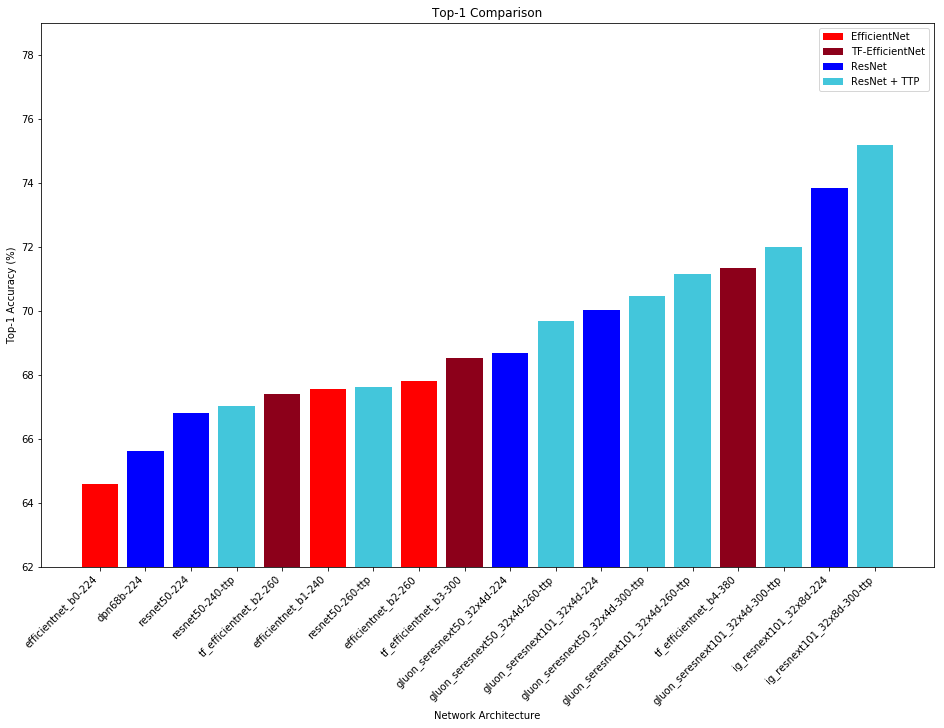

In [11]:
sort_ix = np.argsort(acc_all)
acc_sorted = acc_all[sort_ix]
acc_min, acc_max = acc_sorted[0], acc_sorted[-1]
names_sorted = np.array(names_all)[sort_ix]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ix = np.arange(len(acc_sorted))
ix_effnet = ix[np.in1d(names_sorted[ix], names_effnet)]
ix_effnet_tf = ix[np.in1d(names_sorted[ix], names_effnet_tf)]
ix_resnet = ix[np.in1d(names_sorted[ix], names_resnet)]
ix_resnet_ttp = ix[np.in1d(names_sorted[ix], names_resnet_ttp)]
ax1.bar(ix_effnet, acc_sorted[ix_effnet], color='r', label='EfficientNet')
ax1.bar(ix_effnet_tf, acc_sorted[ix_effnet_tf], color='#8C001A', label='TF-EfficientNet')
ax1.bar(ix_resnet, acc_sorted[ix_resnet], color='b', label='ResNet')
ax1.bar(ix_resnet_ttp, acc_sorted[ix_resnet_ttp], color='#43C6DB', label='ResNet + TTP')
plt.ylim([math.ceil(acc_min - .3*(acc_max - acc_min)),
          math.ceil(acc_max + .3*(acc_max - acc_min))])
ax1.set_title('Top-1 Comparison')
ax1.set_ylabel('Top-1 Accuracy (%)')
ax1.set_xlabel('Network Architecture')
ax1.set_xticks(ix)
ax1.set_xticklabels(names_sorted, rotation='45', ha='right')
ax1.legend()
plt.show()

# Parameter Efficiency

No surprises here, exactly as per the EfficientNet paper, they are in a class of their own in terms of parameter efficiency.

The test time pooling effectively increases the parameter efficiency of the ResNet models, but at the cost of both throughput and memory efficency (see later graphs).

I'm not going to repeat the FLOP differences as there are again no surprises, same as paper barring differences in the models being compare to. If you are looking at FLOP counts for the EfficientNet models, do keep in mind, their counts appear to be for inference optiized models with the BatcNorm layers fused. The counts will be higher if you're working with trainable models that still have their BN layers. You can see some counts I did on ONNX optimized models here (https://github.com/rwightman/gen-efficientnet-pytorch/blob/master/BENCHMARK.md)

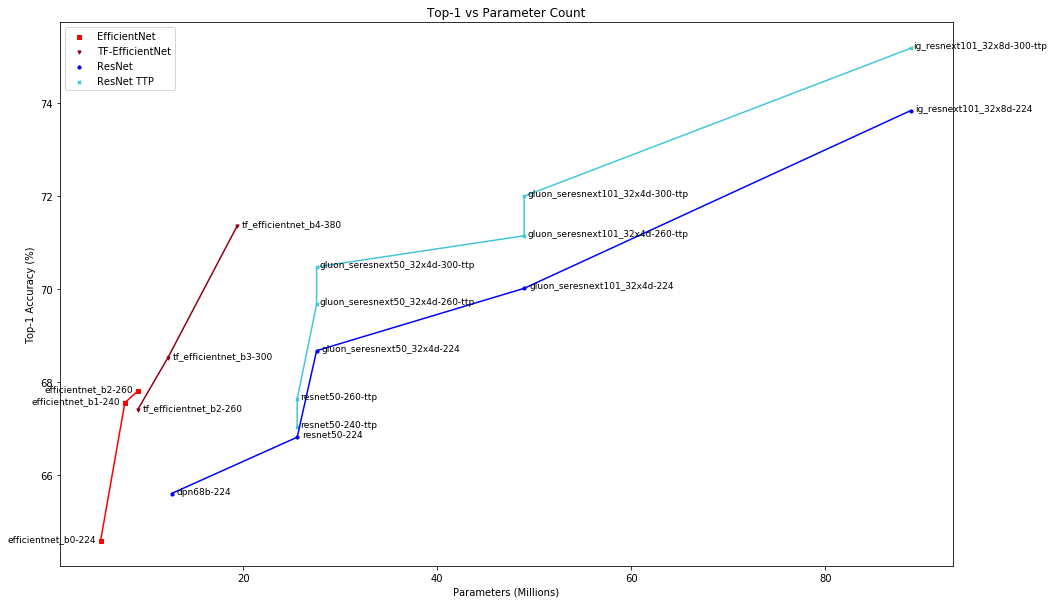

In [12]:
params_effnet = np.array([results[m]['param_count'] for m in names_effnet])
params_effnet_tf = np.array([results[m]['param_count'] for m in names_effnet_tf])
params_resnet = np.array([results[m]['param_count'] for m in names_resnet])
params_resnet_ttp = np.array([results[m]['param_count'] for m in names_resnet_ttp])

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(params_effnet, acc_effnet, s=10, c='r', marker="s", label='EfficientNet')
ax1.plot(params_effnet, acc_effnet, c='r')
annotate(ax1, params_effnet, acc_effnet, names_effnet, xo=-.5, align='right')

ax1.scatter(params_effnet_tf, acc_effnet_tf, s=10, c='#8C001A', marker="v", label='TF-EfficientNet')
ax1.plot(params_effnet_tf, acc_effnet_tf, c='#8C001A')
annotate(ax1, params_effnet_tf, acc_effnet_tf, names_effnet_tf, xo=.5, align='left')

ax1.scatter(params_resnet, acc_resnet, s=10, c='b', marker="o", label='ResNet')
ax1.plot(params_resnet, acc_resnet, c='b')
annotate(ax1, params_resnet, acc_resnet, names_resnet, xo=0.5, align='left')

ax1.scatter(params_resnet_ttp, acc_resnet_ttp, s=10, c='#43C6DB', marker="x", label='ResNet TTP')
ax1.plot(params_resnet_ttp, acc_resnet_ttp, c='#43C6DB')
annotate(ax1, params_resnet_ttp, acc_resnet_ttp, names_resnet_ttp, xo=0.3, align='left')

ax1.set_title('Top-1 vs Parameter Count')
ax1.set_ylabel('Top-1 Accuracy (%)')
ax1.set_xlabel('Parameters (Millions)')
ax1.legend()
plt.show()

# Image Throughput

One of the first thing I noticed running batches through my first ported EfficientNet weights -- the image throughput does not scale with FLOP or parameter counts. Much larger ResNet, DPN, etc. models can match the throughput of EfficientNet models with far fewer parameters and FLOPS. I've trained on many of these models and training throughputs do -- in relative terms -- mirror the validation numbers here.

This was surprising to me given the FLOP ratios. I'd like to see an in depth comparison with Tensorflow,  XLA enabled, targeted for both GPU and TPU.

In [13]:
print('Results by image rate:')
results_by_rate = list(sorted(results.keys(), key=lambda x: results[x]['rate'], reverse=True))
for m in results_by_rate:
  print('  Model: {:34}, Rate: {:4.2f}, Top-1 {}, Top-5: {}'.format(m, results[m]['rate'], results[m]['top1'], results[m]['top5']))
print()


Results by image rate:
  Model: efficientnet_b0-224               , Rate: 165.73, Top-1 64.58, Top-5: 85.89
  Model: resnet50-224                      , Rate: 159.51, Top-1 66.81, Top-5: 87.0
  Model: dpn68b-224                        , Rate: 155.15, Top-1 65.6, Top-5: 85.94
  Model: resnet50-240-ttp                  , Rate: 154.35, Top-1 67.02, Top-5: 87.04
  Model: efficientnet_b1-240               , Rate: 151.63, Top-1 67.55, Top-5: 87.29
  Model: gluon_seresnext50_32x4d-224       , Rate: 150.43, Top-1 68.67, Top-5: 88.32
  Model: efficientnet_b2-260               , Rate: 144.20, Top-1 67.8, Top-5: 88.2
  Model: tf_efficientnet_b2-260            , Rate: 142.73, Top-1 67.4, Top-5: 87.58
  Model: resnet50-260-ttp                  , Rate: 135.92, Top-1 67.63, Top-5: 87.63
  Model: gluon_seresnext101_32x4d-224      , Rate: 131.57, Top-1 70.01, Top-5: 88.91
  Model: gluon_seresnext50_32x4d-260-ttp   , Rate: 126.52, Top-1 69.67, Top-5: 88.62
  Model: tf_efficientnet_b3-300            , Ra

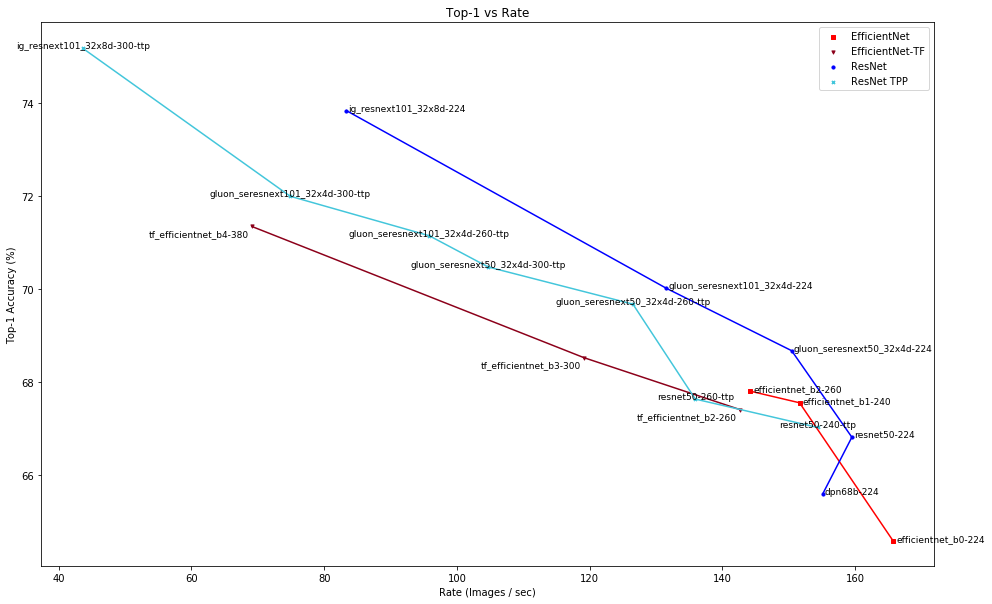

In [14]:
rate_effnet = np.array([results[m]['rate'] for m in names_effnet])
rate_effnet_tf = np.array([results[m]['rate'] for m in names_effnet_tf])
rate_resnet = np.array([results[m]['rate'] for m in names_resnet])
rate_resnet_ttp = np.array([results[m]['rate'] for m in names_resnet_ttp])

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(rate_effnet, acc_effnet, s=10, c='r', marker="s", label='EfficientNet')
ax1.plot(rate_effnet, acc_effnet, c='r')
annotate(ax1, rate_effnet, acc_effnet, names_effnet, xo=.5, align='left')

ax1.scatter(rate_effnet_tf, acc_effnet_tf, s=10, c='#8C001A', marker="v", label='EfficientNet-TF')
ax1.plot(rate_effnet_tf, acc_effnet_tf, c='#8C001A')
annotate(ax1, rate_effnet_tf, acc_effnet_tf, names_effnet_tf, xo=-.5, yo=-.2, align='right')

ax1.scatter(rate_resnet, acc_resnet, s=10, c='b', marker="o", label='ResNet')
ax1.plot(rate_resnet, acc_resnet, c='b')
annotate(ax1, rate_resnet, acc_resnet, names_resnet, xo=.3, align='left')

ax1.scatter(rate_resnet_ttp, acc_resnet_ttp, s=10, c='#43C6DB', marker="x", label='ResNet TPP')
ax1.plot(rate_resnet_ttp, acc_resnet_ttp, c='#43C6DB')
annotate(ax1, rate_resnet_ttp, acc_resnet_ttp, names_resnet_ttp, xo=0., yo=0., align='center')

ax1.set_title('Top-1 vs Rate')
ax1.set_ylabel('Top-1 Accuracy (%)')
ax1.set_xlabel('Rate (Images / sec)')
ax1.legend()
plt.show()

# GPU Memory Usage

Measuring the 'practical' GPU memory consumption is a bit of a challenge. By 'practical', what I want to capture is relative GPU memory usage that indicates what the likely maximum batch sizes will be. With `cudnn.benchmark = True` set, the torch memory allocator metrics didn't prove reliable. In the end, using pynvml (same output as nvidia-smi) and taking a sample part way through the validation set is the most consistent. 

I've verified the sampling by pushing batch sizes for several of the models to the point where they fail with OOM exception. The relative measures of the memory usage match the relative batch sizes -- I can roughly predict where the largest batch size will be from the measure. 

On a T4 colab instance I pushed:
- efficientnet_b2-260 to a batch size of 480
- tf_efficientnet_b2-260 to a batch size 448 (failed at 480)
- ig_resnext101_32x8d-224 to a batch size of 512

Overall, the EfficientNets are not particularly memory efficient. The monster ResNext101-32x8d with 88M params is more memory efficient at 224x224 than the EfficientNet-B2 at 260x260 with 9.1M. This is especially true for the 'tf' variants with the 'SAME' padding hack enabled, there is up to a 20% penalty for this in memory churn that does impact the max useable batch size.

In [15]:
print('Results by GPU memory usage:')
results_by_mem = list(sorted(results.keys(), key=lambda x: results[x]['gpu_used'], reverse=False))
for m in results_by_mem:
  print('  Model: {:34}, GPU Mem: {}, Rate: {:4.2f}, Top-1 {}, Top-5: {}'.format(m, results[m]['gpu_used'], results[m]['rate'], results[m]['top1'], results[m]['top5']))

Results by GPU memory usage:
  Model: resnet50-224                      , GPU Mem: 1530, Rate: 159.51, Top-1 66.81, Top-5: 87.0
  Model: gluon_seresnext50_32x4d-224       , GPU Mem: 1670, Rate: 150.43, Top-1 68.67, Top-5: 88.32
  Model: gluon_seresnext101_32x4d-224      , GPU Mem: 1814, Rate: 131.57, Top-1 70.01, Top-5: 88.91
  Model: resnet50-240-ttp                  , GPU Mem: 2084, Rate: 154.35, Top-1 67.02, Top-5: 87.04
  Model: gluon_seresnext101_32x4d-260-ttp  , GPU Mem: 2452, Rate: 95.84, Top-1 71.14, Top-5: 89.47
  Model: resnet50-260-ttp                  , GPU Mem: 2532, Rate: 135.92, Top-1 67.63, Top-5: 87.63
  Model: gluon_seresnext50_32x4d-260-ttp   , GPU Mem: 2586, Rate: 126.52, Top-1 69.67, Top-5: 88.62
  Model: dpn68b-224                        , GPU Mem: 2898, Rate: 155.15, Top-1 65.6, Top-5: 85.94
  Model: efficientnet_b0-224               , GPU Mem: 2930, Rate: 165.73, Top-1 64.58, Top-5: 85.89
  Model: gluon_seresnext101_32x4d-300-ttp  , GPU Mem: 3252, Rate: 74.87, T

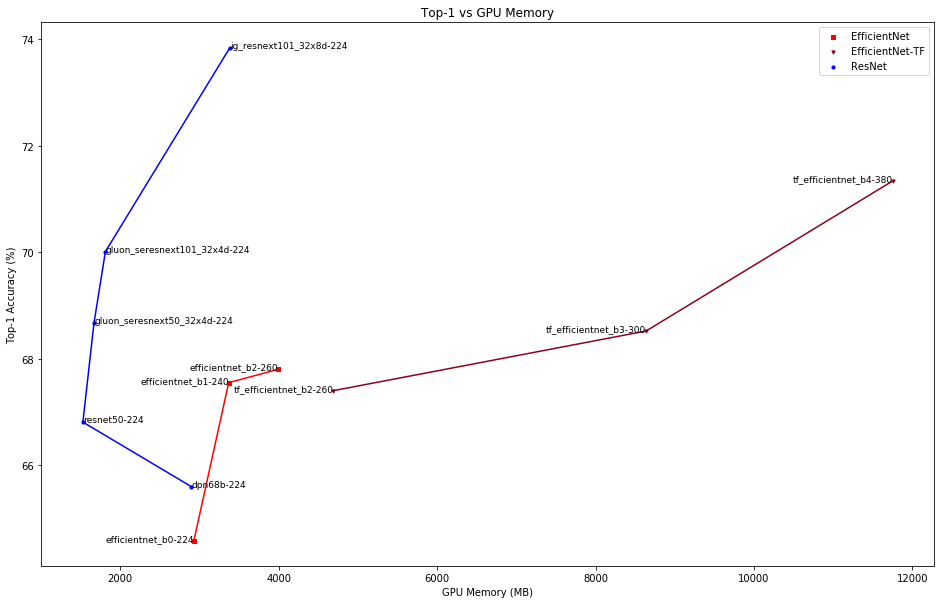

In [16]:
mem_effnet = np.array([results[m]['gpu_used'] for m in names_effnet])
mem_effnet_tf = np.array([results[m]['gpu_used'] for m in names_effnet_tf])
mem_resnet = np.array([results[m]['gpu_used'] for m in names_resnet])
mem_resnet_ttp = np.array([results[m]['gpu_used'] for m in names_resnet_ttp])

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(mem_effnet, acc_effnet, s=10, c='r', marker="s", label='EfficientNet')
ax1.plot(mem_effnet, acc_effnet, c='r')
annotate(ax1, mem_effnet, acc_effnet, names_effnet, xo=-.3, align='right')

ax1.scatter(mem_effnet_tf, acc_effnet_tf, s=10, c='#8C001A', marker="v", label='EfficientNet-TF')
ax1.plot(mem_effnet_tf, acc_effnet_tf, c='#8C001A')
annotate(ax1, mem_effnet_tf, acc_effnet_tf, names_effnet_tf, xo=-.3, align='right')

ax1.scatter(mem_resnet, acc_resnet, s=10, c='b', marker="o", label='ResNet')
ax1.plot(mem_resnet, acc_resnet, c='b')
annotate(ax1, mem_resnet, acc_resnet, names_resnet, xo=.5, align='left')

# Too busy
#ax1.scatter(mem_resnet_ttp, acc_resnet_ttp, s=10, c='#43C6DB', marker="o", label='ResNet TTP')
#ax1.plot(mem_resnet_ttp, acc_resnet_ttp, c='#43C6DB')
#annotate(ax1, mem_resnet_ttp, acc_resnet_ttp, names_resnet_ttp, xo=.5, align='left')

ax1.set_title('Top-1 vs GPU Memory')
ax1.set_ylabel('Top-1 Accuracy (%)')
ax1.set_xlabel('GPU Memory (MB)')
ax1.legend()
plt.show()

# 1 on 1 Comparisons
A few model to model comparisons, pairing models that are a little more fair than the original paper when you consider all of accuracy, rate, and memory efficiency.

In [17]:
def compare_results(results, namea, nameb):
    resa, resb = results[namea], results[nameb]
    top1r = 100. * (resa['top1'] - resb['top1']) / resb['top1']
    top5r = 100. * (resa['top5'] - resb['top5']) / resb['top5']
    rater = 100. * (resa['rate'] - resb['rate']) / resb['rate']
    memr = 100. * (resa['gpu_used'] - resb['gpu_used']) / resb['gpu_used']
    print('{:24} vs {:30} top1: {:+.3f}%, top5: {:+.3f}%, rate: {:+.2f}%, gpu memory: {:+.2f}%'.format(
        namea, nameb, top1r, top5r, rater, memr))
    
#compare_results(results, 'efficientnet_b0-224', 'seresnext26_32x4d-224')
compare_results(results, 'efficientnet_b0-224', 'dpn68b-224')
compare_results(results, 'efficientnet_b1-240', 'resnet50-224')
compare_results(results, 'efficientnet_b1-240', 'resnet50-240-ttp')
compare_results(results, 'efficientnet_b2-260', 'gluon_seresnext50_32x4d-224')
compare_results(results, 'tf_efficientnet_b3-300', 'gluon_seresnext50_32x4d-224')
compare_results(results, 'tf_efficientnet_b3-300', 'gluon_seresnext101_32x4d-224')
compare_results(results, 'tf_efficientnet_b4-380', 'ig_resnext101_32x8d-224')

print('\nNote the cost of running with the SAME padding hack:')
compare_results(results, 'tf_efficientnet_b2-260', 'efficientnet_b2-260')

efficientnet_b0-224      vs dpn68b-224                     top1: -1.555%, top5: -0.058%, rate: +6.82%, gpu memory: +1.10%
efficientnet_b1-240      vs resnet50-224                   top1: +1.108%, top5: +0.333%, rate: -4.94%, gpu memory: +120.26%
efficientnet_b1-240      vs resnet50-240-ttp               top1: +0.791%, top5: +0.287%, rate: -1.76%, gpu memory: +61.71%
efficientnet_b2-260      vs gluon_seresnext50_32x4d-224    top1: -1.267%, top5: -0.136%, rate: -4.14%, gpu memory: +139.04%
tf_efficientnet_b3-300   vs gluon_seresnext50_32x4d-224    top1: -0.218%, top5: +0.430%, rate: -20.81%, gpu memory: +417.25%
tf_efficientnet_b3-300   vs gluon_seresnext101_32x4d-224   top1: -2.128%, top5: -0.236%, rate: -9.45%, gpu memory: +376.19%
tf_efficientnet_b4-380   vs ig_resnext101_32x8d-224        top1: -3.373%, top5: -2.352%, rate: -17.10%, gpu memory: +247.55%

Note the cost of running with the SAME padding hack:
tf_efficientnet_b2-260   vs efficientnet_b2-260            top1: -0.590%, top5:

# How are we generalizing to ImageNet-V2?

This is often an interesting comparison. The results for the IG ResNeXt are impressive, it's the lowest gap between ImageNet-1k and ImageNet-V2 validation scores that I've seen (http://people.csail.mit.edu/ludwigs/papers/imagenet.pdf).

In [18]:
print('Results by absolute accuracy gap between ImageNet-V2 Matched-Frequency and original ImageNet top-1:')
no_ttp_keys = [k for k in results.keys() if 'ttp' not in k]
gaps = {x: (results[x]['top1'] - orig_top1[results[x]['model_name']]) for x in no_ttp_keys}
sorted_keys = list(sorted(no_ttp_keys, key=lambda x: gaps[x], reverse=True))
for m in sorted_keys:
  print('  Model: {:34} {:4.2f}%'.format(m, gaps[m]))
print()

print('Results by relative accuracy gap between ImageNet-V2 Matched-Frequency and original ImageNet top-1:')
gaps = {x: 100 * (results[x]['top1'] - orig_top1[results[x]['model_name']]) / orig_top1[results[x]['model_name']] for x in no_ttp_keys}
sorted_keys = list(sorted(no_ttp_keys, key=lambda x: gaps[x], reverse=True))
for m in sorted_keys:
  print('  Model: {:34} {:4.2f}%'.format(m, gaps[m]))

Results by absolute accuracy gap between ImageNet-V2 Matched-Frequency and original ImageNet top-1:
  Model: ig_resnext101_32x8d-224            -8.86%
  Model: gluon_seresnext101_32x4d-224       -10.89%
  Model: efficientnet_b1-240                -11.14%
  Model: gluon_seresnext50_32x4d-224        -11.24%
  Model: tf_efficientnet_b4-380             -11.26%
  Model: resnet50-224                       -11.68%
  Model: dpn68b-224                         -11.91%
  Model: efficientnet_b2-260                -11.96%
  Model: tf_efficientnet_b2-260             -12.21%
  Model: efficientnet_b0-224                -12.33%
  Model: tf_efficientnet_b3-300             -12.35%

Results by relative accuracy gap between ImageNet-V2 Matched-Frequency and original ImageNet top-1:
  Model: ig_resnext101_32x8d-224            -10.71%
  Model: gluon_seresnext101_32x4d-224       -13.46%
  Model: tf_efficientnet_b4-380             -13.64%
  Model: gluon_seresnext50_32x4d-224        -14.07%
  Model: efficientne